In [1]:
import pandas as pd 
import os
import numpy as np
from matplotlib import pyplot as plt
from rasterio.mask import raster_geometry_mask, mask
import cv2
from FDD import FDD
from FDD.SURE import SURE
import geopandas as gpd
import pickle
import matplotlib as mpl
import boto3

def moveUp(fn, times = 1):
    for _ in range(times):
        fn = os.path.dirname(fn)
    return fn


 #----------------
# parameters
#----------------
S = 32
N = 1000
lmbda = 1000
nu = 0.02
num_samples = 225 # 225 #  400 # 400 # 400 # 200
R =  3 # 3 # 3 # 3 # 5
num_gpus = 1
num_cpus = 2


# get directory above
main_dir = "s3://ipsos-dvd/fdd/" # moveUp(dir, 4)
data_in = os.path.join(main_dir, 'data', 'in')    
data_out = os.path.join(main_dir, 'data', 'out')  


In [48]:

fn_merged = os.path.join(data_out, 'india', 'rajasatan_cheating_grid.geojson')
gdf = gpd.read_file(fn_merged)
# gdf = gdf.to_crs('epsg:3857')

gdf['count_norm'] = gdf['count_norm'] * 100
print(gdf.head())
Y = np.array(gdf['count_norm'])
X = np.stack([np.array(gdf.geometry.centroid.x), np.array(gdf.geometry.centroid.y)]).T

qtile = np.quantile(Y, 0.95)
Y[Y>qtile] = qtile


   count  count_before  count_norm  \
0    0.0             0         0.0   
1    0.0             0         0.0   
2    0.0             0         0.0   
3    0.0             0         0.0   
4    0.0             0         0.0   

                                            geometry  
0  POLYGON ((7649981.161 2531547.755, 7654981.161...  
1  POLYGON ((7654981.161 2531547.755, 7659981.161...  
2  POLYGON ((7659981.161 2531547.755, 7664981.161...  
3  POLYGON ((7659981.161 2536547.755, 7664981.161...  
4  POLYGON ((7654981.161 2536547.755, 7659981.161...  


In [49]:

file_name = 'india_mobile_SURE_95_025_lambda100.pkl'
# get SURE parameters
s3 = boto3.client('s3')
s3.download_file("ipsos-dvd", "fdd/data/out/" + file_name, file_name)
        
with open(file_name, "rb") as f:
    res = pickle.load(f)

best = res.get_best_result(metric = "score", mode = "min")

config = best.metrics['config']
lmbda, nu = config['lmbda'], config['nu']

In [54]:
print(lmbda, nu)

93.80899791496435 0.0011018795982745484


In [87]:
lmbda = 10
nu = 0.003

In [88]:
resolution = 1/int(np.sqrt(0.25*Y.size))
model = FDD(Y, X, level = 32, lmbda = lmbda, nu = nu, iter = 10000, tol = 1e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False, rectangle=True, CI=False)

In [89]:
import time
start_time = time.time()
results = model.run()
end_time = time.time()
execution_time = end_time - start_time
print("Execution time: {:.2f} seconds".format(execution_time))

/home/ubuntu/fdd/src/FDD/primaldual_multi_scaled_tune.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tauu = torch.tensor(  1.0 / torch.sqrt(denom) * res, device=dev)  # torch.tensor(  1.0 / 6.0 * res, device=dev) # *res
/home/ubuntu/fdd/src/FDD/primaldual_multi_scaled_tune.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigmap = torch.tensor( 1.0 / torch.sqrt(denom)  * res, device=dev) # torch.tensor( (1.0 / (3.0 + l))  * res, device=dev) # *res


Execution time: 103.60 seconds


In [90]:
J_grid = results['J']
u = results['u']

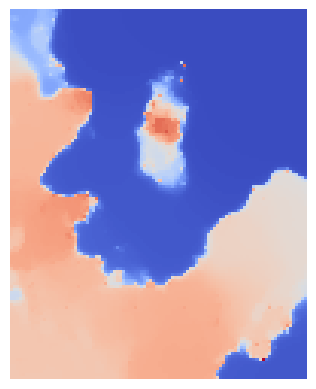

In [93]:
plt.imshow(u, cmap = "coolwarm")
plt.axis("off")
plt.savefig("india_Jgrid.png", bbox_inches="tight")

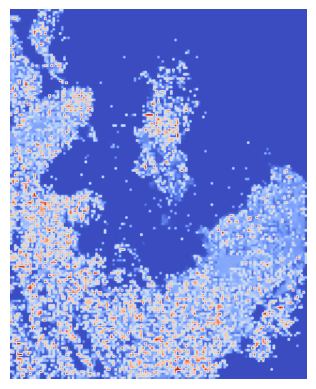

In [19]:
fig = plt.figure()
plt.imshow(u, cmap = "coolwarm")
plt.axis("off")
norm = mpl.colors.Normalize()
cbar = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')
#fig.colorbar(cbar, orientation="vertical", pad=0, label=f"% of Monthly Average")
plt.savefig("india_u.png", bbox_inches="tight")

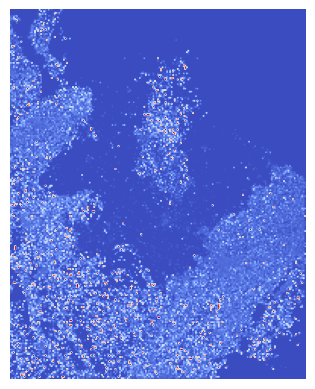

In [46]:
fig = plt.figure()
plt.imshow(model.grid_y, cmap = "coolwarm")
plt.axis("off")
norm = mpl.colors.Normalize()
cbar = plt.cm.ScalarMappable(norm=norm, cmap='coolwarm')

In [47]:
model.grid_y.mean()

0.06890873187075991

In [16]:
from types import MethodType

def boundaryGridToData(self, J_grid, u, average = False):
        # get the indices of the J_grid where J_grid is 1


        k = np.array(np.where(J_grid == 1))
        

        # Store the average points
        Y_jumpfrom = []
        Y_jumpto = []
        Y_jumpsize = []
        Y_boundary = []
        X_jumpfrom = []
        X_jumpto = []


        # Iterate over the boundary points
        for i in range(k.shape[1]):

            origin_points = []
            dest_points = []

            # Get the coordinates of the current boundary point
            point = k[:, i]

            # Initialize a list to store the neighboring hypervoxels
            #neighbors = list(self.explore(point, J_grid))
            neighbors = []  
            count = 0
            for d in range(J_grid.ndim):
                neighbor = point.copy()
                if neighbor[d] < J_grid.shape[d] - 1:
                    neighbor[d] += 1
                    neighbors.append(neighbor)
                    count += 1
            if count == 0:
                neighbors.append(point.copy())
                    

            # Check if there are any valid neighbors
            if neighbors:

                # origin_points
                origin_points = self.grid_x_og[tuple(point)]
                if len(origin_points) == 0:
                    origin_points = self.grid_x[tuple(point)] + self.resolution / 2
                Yjumpfrom = float(u[tuple(point)])


                # jumpfrom point
                origin_points = np.stack(origin_points).squeeze()
                if (origin_points.ndim > 1) | ((origin_points.ndim == 1) and (origin_points.shape[0] > 1)): # if there are multiple points in the hypervoxel, take the mean
                    jumpfrom = np.mean(origin_points, axis = 0)
                else:
                    jumpfrom = origin_points


                # jumpto point
                pointslist = [self.grid_x_og[tuple(neighbors[j])] if self.grid_x_og[tuple(neighbors[j])] != []  # if grid cell is empty, assign centerpoint
                                else [self.grid_x[tuple(neighbors[j])] + self.resolution / 2] for j in range(len(neighbors))]

                if average:
                    counts = [len(pointslist[j]) for j in range(len(neighbors))]
                    total = sum(counts) # TODO: jump sizes on diagonal boundary sections are off
                    Yjumpto = np.sum([(u[tuple(neighbors[j])] * counts[j]) / total for j in range(len(neighbors))]) # proper unweighted average of the y values
                    dest_points = np.stack([item for sublist in pointslist for item in sublist]).squeeze()
                    if dest_points.ndim > 1: # if there are multiple points in the hypervoxel, take the mean
                        jumpto = np.mean(dest_points, axis = 0)
                    else:
                        jumpto = dest_points
                else:
                    # get point with largest jump size
                    Yjumptos = [u[tuple(neighbors[j])] for j in range(len(neighbors))]
                    Yjumpsizes = [abs(Yjumptos[j] - Yjumpfrom) for j in range(len(neighbors))]
                    idx = np.argmax(Yjumpsizes)
                    Yjumpto = Yjumptos[idx]
                    dest_points = self.grid_x_og[tuple(neighbors[idx])]
                    if len(dest_points) == 0:
                        dest_points = self.grid_x[tuple(neighbors[idx])] + self.resolution / 2
                    dest_points = np.stack(dest_points).squeeze()
                    
                    if (dest_points.ndim > 1) or ((dest_points.ndim == 1) and (dest_points.shape[0] > 1)): # if there are multiple points in the hypervoxel, take the mean
                        jumpto = np.mean(dest_points, axis = 0)
                    else:
                        jumpto = dest_points
                    
                    # dists = [[np.linalg.norm(jumpfrom - point) for point in pointslist[j]] for j in range(len(neighbors))]
                    # idx = np.argmin([np.argmin(sublist) for sublist in dists])
                    # closest = tuple(neighbors[idx])
                    # Yjumpto = u[closest]

                    # dest_points = self.grid_x_og[closest]
                    # if len(dest_points) == 0:
                    #     dest_points = self.grid_x[closest] + self.resolution / 2
                    # dest_points = np.stack(dest_points).squeeze()

                    # if dest_points.ndim > 1: # if there are multiple points in the hypervoxel, take the mean
                    #     jumpto = np.mean(dest_points, axis = 0)
                    # else:
                    #     jumpto = dest_points
                        

                # append to lists
                Y_boundary.append(1) # (jumpfrom + jumpto) / 2)
                Y_jumpfrom.append(Yjumpfrom)
                Y_jumpto.append(Yjumpto)
                Y_jumpsize.append(Yjumpto - Yjumpfrom)
                X_jumpfrom.append(jumpfrom)
                X_jumpto.append(jumpto)

        if Y_boundary:
            Y_boundary = np.stack(Y_boundary)
            Y_jumpfrom = np.stack(Y_jumpfrom)
            Y_jumpto = np.stack(Y_jumpto)
            Y_jumpsize = np.stack(Y_jumpsize)
            
            if Y_boundary.ndim == 1:
                Y_boundary = np.expand_dims(Y_boundary, -1)
        

            # create named array to return
            rays = [Y_boundary[:,d] for d in range(Y_boundary.shape[1])] + [Y_jumpfrom, Y_jumpto, Y_jumpsize]
            names = ["X_" + str(d) for d in range(Y_boundary.shape[1])] + ["Y_jumpfrom", "Y_jumpto", "Y_jumpsize"]
            jumps = pd.DataFrame(np.core.records.fromarrays(rays, names=names))
        else:
            jumps = None

        return jumps


model.boundaryGridToData = MethodType(boundaryGridToData, model)


In [70]:
# plot treatment effect curve
jumps = model.boundaryGridToData(J_grid, u)
jumpdf = pd.DataFrame(jumps)

jumpdf['Y_jumpsize'] = jumpdf['Y_jumpsize'].abs()

Xplot = np.zeros(model.grid_x.shape[:-1])

for index,row in jumpdf.iterrows():
  Xplot[int(row['X_0'] / model.resolution), int(row['X_1'] / model.resolution)] = np.abs(row['Y_jumpsize'])
#Xplot = Xplot * 100

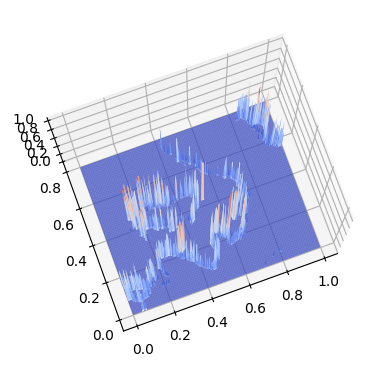

In [94]:
from mpl_toolkits.mplot3d.axes3d import *
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(model.grid_x[...,1], model.grid_x[...,0], Xplot, 
                rstride=1, cstride=1,linewidth=1, antialiased=True, cmap = "coolwarm")
ax.set_axis_on()
ax.axis("scaled")
# ax.grid(False)
# ax.set_xticks([])
# ax.set_yticks([])

# # Set the view angle
ax.view_init(elev=80, azim=-110)
plt.savefig("india_treatmentcurve.png", bbox_inches="tight")

In [35]:
Xplot[Xplot > 0]

array([0.40707931])

In [15]:
jumpdf

,X_0,X_1,Y_jumpfrom,Y_jumpto,Y_jumpsize
0,0.001832,0.078755,0.197722,0.794182,0.407079
1,0.001832,0.134615,0.739607,0.946372,0.407079
2,0.001832,0.140110,0.946372,0.405274,0.407079
3,0.001832,0.144689,0.405274,0.192470,0.407079
4,0.007326,0.078755,0.197121,0.781236,0.407079
...,...,...,...,...,...
1349,0.990842,0.564103,0.220876,0.710486,0.407079
1350,0.995421,0.560440,0.741536,0.427937,0.407079
1351,0.992674,0.565934,0.710486,0.192783,0.407079
1352,0.998168,0.558608,0.652823,0.427937,0.407079


In [4]:
import pandas as pd 
import os
import numpy as np
from matplotlib import pyplot as plt
from rasterio.mask import raster_geometry_mask, mask
import cv2
from FDD import FDD
from FDD.SURE import SURE
import geopandas as gpd
import pickle

def moveUp(fn, times = 1):
    for _ in range(times):
        fn = os.path.dirname(fn)
    return fn


 #----------------
# parameters
#----------------
S = 32
N = 1000
lmbda = 1000
nu = 0.02
num_samples = 2 # 225 #  400 # 400 # 400 # 200
R =  1 # 3 # 3 # 3 # 5
num_gpus = 1
num_cpus = 2


# get directory above
main_dir = "/home/dvdijcke/" # moveUp(dir, 4)
data_in = os.path.join(main_dir, 'data', 'in')    
data_out = os.path.join(main_dir, 'data', 'out')  

fn_merged = os.path.join(data_out, 'india', 'rajasatan_cheating_grid.geojson')
gdf = gpd.read_file(fn_merged)
gdf = gdf.to_crs('epsg:3857')

gdf['count_norm'] = gdf['count_norm'] * 100
Y = np.array(gdf['count_norm'])
X = np.stack([np.array(gdf.geometry.centroid.x), np.array(gdf.geometry.centroid.y)]).T

qtile = np.quantile(Y, 0.95)
Y[Y>qtile] = qtile

resolution = 1/int(np.sqrt(0.25*Y.size))
model = FDD(Y, X, level = 32, lmbda = 150, nu = 0.008, iter = 10000, tol = 5e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False, rectangle=True)

# res = SURE(tuner=True, num_samples=num_samples, model=model, R=R, 
#     num_gpus=num_gpus, num_cpus=num_cpus)

In [3]:
resolution = 1/int(np.sqrt(0.25*Y.size))
model = FDD(Y, X, level = 32, lmbda = 150, nu = 0.008, iter = 10000, tol = 5e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False, rectangle=True)

In [5]:
X.max()

9017481.160830013

In [6]:
X.min()

2534047.754779711

In [10]:
gdf.geometry.centroid.y

0        2.534048e+06
1        2.534048e+06
2        2.534048e+06
3        2.539048e+06
4        2.539048e+06
             ...     
60001    2.539048e+06
60002    2.539048e+06
60003    2.534048e+06
60004    2.534048e+06
60005    2.534048e+06
Length: 60006, dtype: float64

In [11]:
model = FDD(Y, X, level = 32, lmbda = 150, nu = 0.008, iter = 10000, tol = 5e-5, resolution=resolution,
    pick_nu = "MS", scaled = True, scripted = False, rectangle=True)

In [13]:
gdf.to_crs("epsg:3857")

,count,count_before,count_norm,geometry
0,0.0,0,0.0,"POLYGON ((7649981.161 2531547.755, 7654981.161..."
1,0.0,0,0.0,"POLYGON ((7654981.161 2531547.755, 7659981.161..."
2,0.0,0,0.0,"POLYGON ((7659981.161 2531547.755, 7664981.161..."
3,0.0,0,0.0,"POLYGON ((7659981.161 2536547.755, 7664981.161..."
4,0.0,0,0.0,"POLYGON ((7654981.161 2536547.755, 7659981.161..."
...,...,...,...,...
60001,0.0,0,0.0,"POLYGON ((9009981.161 2536547.755, 9014981.161..."
60002,0.0,0,0.0,"POLYGON ((9004981.161 2536547.755, 9009981.161..."
60003,0.0,6,0.0,"POLYGON ((9004981.161 2531547.755, 9009981.161..."
60004,0.0,0,0.0,"POLYGON ((9009981.161 2531547.755, 9014981.161..."
